In [1]:
# Environment
import gym 
import highway_env
import inspect
print(inspect.getfile(highway_env))

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
# torch.set_default_tensor_type("torch.cuda.FloatTensor")

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import RecordVideo
import base64

# IO
from pathlib import Path
# print(torch.cuda.is_available())
# print(torch.__version__)
# print(torch.cuda.get_device_name(0)) # CUDA : 10.1


C:\Users\82104\AppData\Roaming\Python\Python39\site-packages\highway_env\__init__.py


In [2]:
def show_video(path):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

In [3]:
Transition = namedtuple('Transition', ['state', 'action', 'next_state'])
env = gym.make("parking-v0")

def collect_interaction_data(env, size=1000, action_repeat=1):
    data, done = [], True
    for _ in trange(size, desc="Collecting interaction data"): 
        action = env.action_space.sample()
        for _ in range(action_repeat): 
            previous_obs = env.reset() if done else obs
            if isinstance(previous_obs, tuple) :
                previous_obs = previous_obs[0]
                
                

            obs, reward, done, inf1, info2 = env.step(action)

            
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
    return data

data = collect_interaction_data(env)
print("Sample transition:", data[0])
len(data)

Sample transition: Transition(state=tensor([ 0.0000,  0.0000,  0.0000, -0.0000,  0.0249, -0.9997]), action=tensor([0.3841, 0.3663]), next_state=tensor([ 4.3852e-05, -2.5226e-04,  2.0280e-03, -7.6785e-02,  2.6403e-02,
        -9.9965e-01]))


1000

In [4]:
class DynamicsModel(nn.Module):
    STATE_X = 0
    STATE_Y = 1

    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        A_size, B_size = state_size * state_size, state_size * action_size
        self.A1 = nn.Linear(state_size + action_size, hidden_size)
        self.A2 = nn.Linear(hidden_size, A_size)
        self.B1 = nn.Linear(state_size + action_size, hidden_size)
        self.B2 = nn.Linear(hidden_size, B_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        """
        xu = torch.cat((x, u), -1)
        xu[:, self.STATE_X:self.STATE_Y+1] = 0  # Remove dependency in (x,y)
        A = self.A2(F.relu(self.A1(xu)))
        A = torch.reshape(A, (x.shape[0], self.state_size, self.state_size))
        B = self.B2(F.relu(self.B1(xu)))
        B = torch.reshape(B, (x.shape[0], self.state_size, self.action_size))
        dx = A @ x.unsqueeze(-1) + B @ u.unsqueeze(-1)
        return x + dx.squeeze()*self.dt

dynamics = DynamicsModel(state_size=env.observation_space.spaces["observation"].shape[0],
                         action_size=env.action_space.shape[0],
                         hidden_size=64,
                         dt=1/env.unwrapped.config["policy_frequency"])

Train dynamics:   0%|          | 0/1500 [00:00<?, ?it/s]

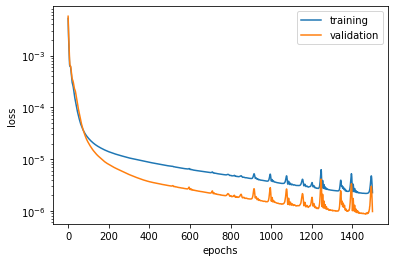

In [5]:
optimizer = torch.optim.Adam(dynamics.parameters(), lr=0.01)

# Split dataset into training and validation
train_ratio = 0.7
train_data, validation_data = data[:int(train_ratio * len(data))], \
                              data[int(train_ratio * len(data)):]

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

def train(model, train_data, validation_data, epochs=1500):
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)
    for epoch in trange(epochs, desc="Train dynamics"):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["training", "validation"])
    plt.show()

train(dynamics, data, validation_data)

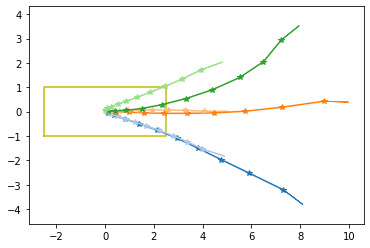

In [6]:
def predict_trajectory(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat): #1개의 초기 acrion 당 15개의 경로 지점 예상
            state = model(state, action)
            states.append(state)
    # print('predicted trace for 1 state, action pair')        
    # print(torch.stack(states, dim=0))
    return torch.stack(states, dim=0)

def plot_trajectory(states, color):
    scales = np.array(env.unwrapped.config["observation"]["scales"])
    states = np.clip(states.squeeze(1).detach().numpy() * scales, -100, 100)
    plt.plot(states[:, 0], states[:, 1], color=color, marker='*')
    plt.arrow(states[-1,0], states[-1,1], states[-1,4]*1, states[-1,5]*1, color=color)

def visualize_trajectories(model, state, horizon=10):
    plt.cla()
    # Draw a car
    plt.plot(state.numpy()[0]+2.5*np.array([-1, -1, 1, 1, -1]),
             state.numpy()[1]+1.0*np.array([-1, 1, 1, -1, -1]), 'y') # 자동차 그리는 부분
    # Draw trajectories
    state = state.unsqueeze(0)
    colors = iter(plt.get_cmap("tab20").colors)

    # Generate commands
    for steering in np.linspace(-0.5, 0.5, 3):
        for acceleration in np.linspace(0.8, 0.4, 2): # 초기 action 6가지 경우에 대해

            actions = torch.Tensor([acceleration, steering]).view(1,1,-1)
            # Predict trajectories
            states = predict_trajectory(state, actions, model, action_repeat=horizon)
            plot_trajectory(states, color=next(colors))
    plt.axis("equal")
    plt.show()


visualize_trajectories(dynamics, state=torch.Tensor([0, 0, 0, 0, 1, 0]))


In [7]:
def reward_model(states, goal, gamma=None):
    '''
    reward = 루트((state-goal) * [1, 0.3, 0, 0, 0.02, 0.02])
    '''
    goal = goal.expand(states.shape) 
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5) # 
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards

obs = env.reset()[0]
print("Reward of a sample transition:", reward_model(torch.Tensor(obs["observation"]).unsqueeze(0),
                                                     torch.Tensor(obs["desired_goal"]), ))

print("observation: ",obs["observation"])
print("desired_goal: ",obs["desired_goal"])

Reward of a sample transition: tensor([-0.4583])
observation:  [ 0.         0.         0.        -0.         0.8783447 -0.4780278]
desired_goal:  [ 1.400000e-01 -1.400000e-01  0.000000e+00  0.000000e+00  6.123234e-17
 -1.000000e+00]


In [8]:
# Cross entropy method
def cem_planner(state, goal, action_size, horizon=5, population=100, selection=10, iterations=5):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)
    for _ in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        actions = action_mean + action_std * torch.normal(0, 1, size = (horizon, population, action_size))
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        states = predict_trajectory(state, actions, dynamics, action_repeat=1)
        # 2. Fit the distribution to the top-k performing sequences
        returns = reward_model(states, goal).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]
        action_mean, action_std = best_actions.mean(dim=1, keepdim=True), best_actions.std(dim=1, unbiased=False, keepdim=True)
    return action_mean[0].squeeze(dim=0)
  
  
# Run the planner on a sample transition
action = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0])
print("Planned action:", action)

Planned action: tensor([0.9565, 0.4371])


In [9]:
from tqdm import trange

env = gym.make("parking-v0")
# env.configure({"vehicles_count": 10})
env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda e: True)
env.unwrapped.set_record_video_wrapper(env)
for episode in trange(20, desc="Test episodes"):
    obs, done = env.reset(), False
    t = 0
    while ((not done) and (t <70)) :
        if len(obs) == 2:
            action = cem_planner(torch.Tensor(obs[0]["observation"]),
                            torch.Tensor(obs[0]["desired_goal"]),
                            env.action_space.shape[0])
        elif len(obs) ==3:
            action = cem_planner(torch.Tensor(obs["observation"]),
                            torch.Tensor(obs["desired_goal"]),
                            env.action_space.shape[0])
        obs, reward, done, info, _ = env.step(action.numpy())
        t = t+1

env.close()
show_video('./video')

C:\Users\82104\AppData\Roaming\Python\Python39\site-packages\gym\wrappers\record_video.py:75: UserWarning: WARN: Overwriting existing videos at c:\Users\82104\OneDrive - 성균관대학교\3-2 (진짜)\1. 강화학습\제출한 과제\기말과제\videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
Test episodes:   0%|          | 0/20 [00:00<?, ?it/s]C:\Users\82104\AppData\Roaming\Python\Python39\site-packages\gym\wrappers\monitoring\video_recorder.py:59: UserWarning: WARN: Disabling video recorder because environment <OrderEnforcing<PassiveEnvChecker<ParkingEnv<parking-v0>>>> was not initialized with any compatible video mode between `rgb_array` and `rgb_array_list`
  logger.warn(
C:\Users\82104\AppData\Roaming\Python\Python39\site-packages\gym\utils\passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(
Test